https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.01&regularizationRate=0.01&noise=0&networkShape=4,2&seed=0.56501&showTestData=false&discretize=false&percTrainData=60&x=true&y=true&xTimesY=true&xSquared=true&ySquared=true&cosX=false&sinX=true&cosY=false&sinY=true&collectStats=false&problem=classification&initZero=false&hideText=false
2k

https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.1&regularizationRate=0.001&noise=0&networkShape=4,2&seed=0.56501&showTestData=false&discretize=false&percTrainData=60&x=true&y=true&xTimesY=true&xSquared=false&ySquared=false&cosX=false&sinX=true&cosY=false&sinY=true&collectStats=false&problem=classification&initZero=false&hideText=false
1k

https://playground.tensorflow.org/#activation=tanh&regularization=L2&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0.01&noise=0&networkShape=5,2&seed=0.56501&showTestData=false&discretize=false&percTrainData=60&x=true&y=true&xTimesY=true&xSquared=false&ySquared=false&cosX=false&sinX=true&cosY=false&sinY=true&collectStats=false&problem=classification&initZero=false&hideText=false
500 -> 0.048

https://playground.tensorflow.org/#activation=tanh&regularization=L2&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0.01&noise=0&networkShape=5,2&seed=0.56501&showTestData=false&discretize=false&percTrainData=60&x=true&y=true&xTimesY=true&xSquared=false&ySquared=false&cosX=false&sinX=true&cosY=false&sinY=true&collectStats=false&problem=classification&initZero=false&hideText=false
350 -> 0.045

In [1]:
import tensorflow as tf
from  tensorflow.keras.datasets  import  mnist 
from  tensorflow.keras.utils  import  to_categorical
from  tensorflow.keras  import  Input 
from  tensorflow.keras.layers  import  Dense, Dropout
from  tensorflow.keras.models  import  Model 
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

import numpy as np

import matplotlib.pyplot as plt
import  os 
import random
import numpy as np
import tensorflow as tf


random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# # Увімкнення детермінізму в TensorFlow (для GPU-операцій)
# # tf.config.experimental.enable_op_determinism()

2024-12-13 14:44:49.932226: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 14:44:49.940111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734093889.949415  154270 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734093889.952136  154270 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 14:44:49.962091: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# завантажимо датасет
data = mnist.load_data ()

In [3]:
# з документації знаємо що датасет вже поділено на тренувальну та тестові вибірки, тож просто розпакуємо
(X_train, y_train), (X_test, y_test) = data
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")

X_train: (60000, 28, 28)
X_test: (10000, 28, 28)


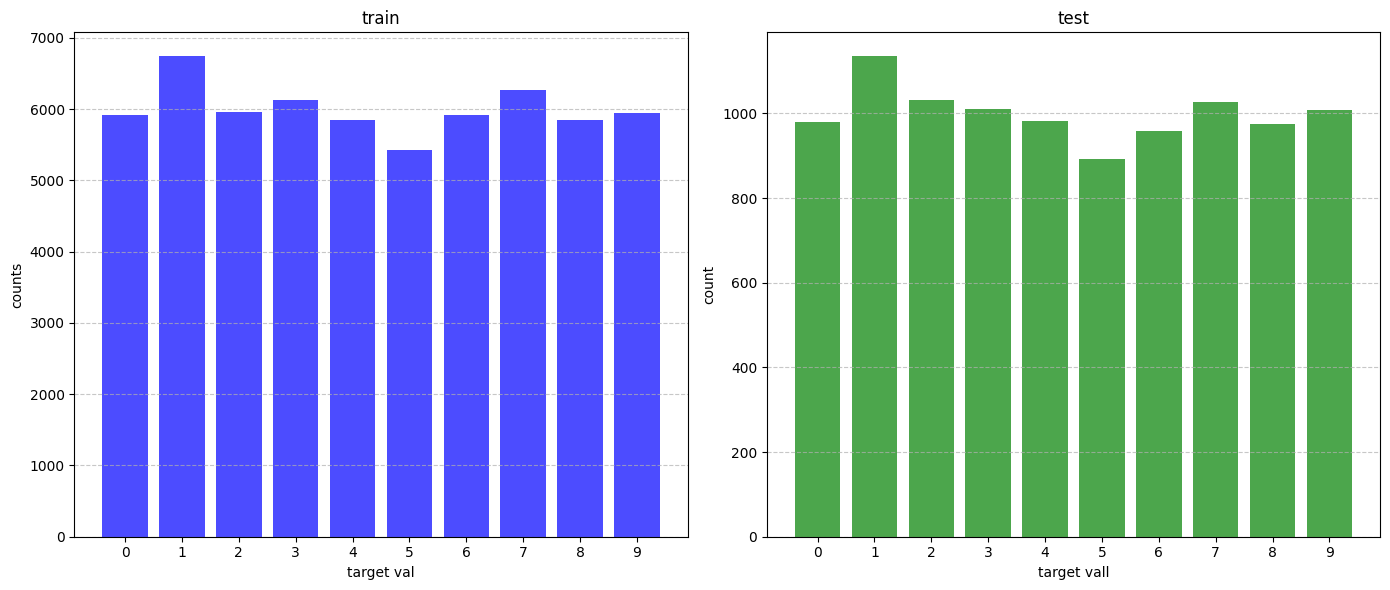

In [4]:
# цікавості та практики заради подивимось на рохподіл таргетів в тренувальній та тестовій вибірках


unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)


plt.figure(figsize=(14, 6))

# для тренувальної вибірки
plt.subplot(1, 2, 1)
plt.bar(unique_train, counts_train, color='blue', alpha=0.7)
plt.title('train')
plt.xlabel('target val')
plt.ylabel('counts')
plt.xticks(unique_train)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# для тестової вибірки
plt.subplot(1, 2, 2)
plt.bar(unique_test, counts_test, color='green', alpha=0.7)
plt.title('test')
plt.xlabel('target vall')
plt.ylabel('count')
plt.xticks(unique_test)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

In [5]:
# супер. Бачимо що наші значення вже розподілені +- рівномірно в рамках кожної вибірки та з відповідною частотою між вибірками. Тож перерозподіляти дані не будемо

In [6]:
# створимо функцію, яка буде записувати наші логи

def get_path(log_dir):
    i = 0
    while(True):
        log_path = os.path.join(log_dir, str(i))
        if not os.path.isdir(log_path):
            return log_path
        i = i + 1

In [7]:
# якщо ми плануємо використовувати лише Dense - шари, то ми маємо перетворити наші зображення, які представлені у вигляді матриць 28*28 на вектори
X_train = X_train.reshape(X_train.shape[0], -1) # ",-1" == Xtrain.shape[1] * X_train.shape[2]
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape, X_test.shape)

(60000, 784) (10000, 784)


In [8]:
# подивимось на діапазони даних. Так як зображення у MNIST представлені у градаціях сірого - вони мають бути в діапазоні 0 - 255. Перевіримо це

print(np.min(X_train), " - ", np.max(X_train))

0  -  255


In [9]:
# нормалізуємо дані в діапазон від 0 до 1
X_train, X_test = map(lambda x: x / 255, [X_train, X_test])
print(np.min(X_train), " - ", np.max(X_train))

0.0  -  1.0


In [10]:
# наші таргети представлені у вигляді цілих чисел від 0 до 9. Тож ми можемо або не перетворювати їх і використовувати як єб 
# або перетворити через tf.keras.utils.to_categorical на вектори імовірностей. Зайвих кроків робити не будемо

num_classes = len(np.unique(y_train))

#input = Input(shape=(X_train.shape[1], )) # кількість входів має відповідати кількості елементів вектора, що подається
input = Input(shape=(X_train.shape[1], )) # кількість входів має відповідати кількості елементів вектора, що подається
hidden_1 = Dense(20, activation="relu", )(input)
#hidden_1 = Dense(20, activation="relu", kernel_regularizer=regularizers.l2(0.0001))(input) # додавши щє один шар, ми змогли підвищіти accuracy p 92.5 до 96.17, за рахунок суттєвого ускладнення моделі
#dropout = Dropout(.2)(hidden_1) # зі зменшенням регулярізації трохи піднялась точність, але почали проявлятись показники імовірного перенавчання
output = Dense(num_classes, activation="softmax")(hidden_1)
model = Model(inputs=input, outputs=output)

I0000 00:00:1734093891.619623  154270 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22109 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,910 (62.15 KB)

 Trainable params: 15,910 (62.15 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:


optimizer = SGD(learning_rate=0.1)
model.compile(loss='sparse_categorical_crossentropy',  # якщо ми бажаємо використовувати categorical_crossentropy - маємо перетворити таргети на вектори імовірностей
              optimizer=optimizer,  
              metrics=['accuracy'])

In [13]:
2e-04


0.0002

In [14]:
EPOCHS = 200

In [15]:
def scheduler(epoch, lr):
    # функція знижує lr при досягненні половини та трьох чвертей із запланованих епох для більш плавного спуску по градієнту
    if epoch == round(EPOCHS * .5):
        return lr *.7
    elif epoch == round(EPOCHS * .75):
        return lr * .3
    return lr



In [16]:
#Зробимо свій кастомний колбек, який буде зберігати локально графіки loss та accuracy
from keras.callbacks import Callback

In [17]:
from collections import defaultdict



class PlotCallbeck(Callback):
    def __init__(self, log_path, figsize:tuple=(15, 10)):
        super().__init__()
        self.log_path = log_path
        self.metrics = defaultdict(list)
        self.figsize = figsize

        if not os.path.exists(self.log_path):
            os.makedirs(self.log_path)

    def on_epoch_end(self, epoch, logs=None):
        for key in logs.keys():
            self.metrics[key].append(logs[key])
        
        self._plot_metrics()

    def _plot_metrics(self):
        
        for metric in self.metrics:
            if "val_" in metric:
                continue
            plt.figure(figsize=self.figsize)
            plt.plot(self.metrics[metric], label=metric)
            validation_pair = self.metrics.get(f"val_{metric}", None)

            if validation_pair is not None:
                plt.plot(validation_pair, label=f"val_{metric}")
        
            plt.xlabel("epoch")
            plt.ylabel(metric)
            plt.title(f"training and validation {metric}")
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(self.log_path, f"{metric}.png"))
            plt.close()


In [18]:
logpath = get_path("./model_logs")
best_model_path = os.path.join(logpath, "best_model.keras")

tnsrbrd = TensorBoard(log_dir=logpath)  # для запуску tensorboard --logdir={log_dir}
best_model_cp = ModelCheckpoint(best_model_path, save_best_only=True, monitor="val_accuracy", verbose=1)
early_stopping_cp = EarlyStopping(monitor="val_accuracy", min_delta=1e-05, patience=15, restore_best_weights=False, start_from_epoch=10, verbose=1)
# restore_best_weights=True - частково дублює функціонал ModelCallback: обидва забезпечують що ми отримаємо найкращу модель за обраноюу метрикою,
# але  ModelCallback зберігає модель у файл, а restore_best_weights просто відновлює ваги найкращої моделі
lr_scheduler_cp = LearningRateScheduler(scheduler, verbose=1)
plateu_down_cp = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=10, min_delta=0.0001, cooldown=5, min_lr=0.0001)  # без цього калбека early_stopping_cp спрацював
        # на 136 ітерації, з ним на 101. За рахунок більш гладкого зниження по градієнту
on_epoch_end_cp = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"[lambda_callback ]{epoch}: {logs}"))  # просто для розуміння
plot_cp = PlotCallbeck(logpath)  # тепер ми можемо передивитись графіки для кожного тренування та/або наблюдати за ними у реальному часі


model.fit(X_train, y_train,
        batch_size=252,
        epochs=EPOCHS,
        verbose=0,
        validation_split=0.15,
        callbacks=[tnsrbrd, best_model_cp, early_stopping_cp, lr_scheduler_cp, plateu_down_cp, on_epoch_end_cp, plot_cp]
        )

score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

# не можу наразі оновити драйвери NVIDIA, через те що мені потрібна саме ція версія. Тож позивемо поки що так..


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.


I0000 00:00:1734093892.635325  154370 service.cc:148] XLA service 0x79a9b8004d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734093892.635342  154370 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-12-13 14:44:52.641208: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734093892.656485  154370 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-13 14:44:52.668883: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-12-13 14:44:5


Epoch 1: val_accuracy improved from -inf to 0.89544, saving model to ./model_logs/35/best_model.keras
[lambda_callback ]0: {'accuracy': 0.7749999761581421, 'loss': 0.801936686038971, 'val_accuracy': 0.8954444527626038, 'val_loss': 0.3746677041053772, 'learning_rate': 0.10000000149011612}

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.

Epoch 2: val_accuracy improved from 0.89544 to 0.91311, saving model to ./model_logs/35/best_model.keras
[lambda_callback ]1: {'accuracy': 0.894725501537323, 'loss': 0.37135687470436096, 'val_accuracy': 0.9131110906600952, 'val_loss': 0.2983444333076477, 'learning_rate': 0.10000000149011612}

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.

Epoch 3: val_accuracy improved from 0.91311 to 0.92189, saving model to ./model_logs/35/best_model.keras
[lambda_callback ]2: {'accuracy': 0.9095882177352905, 'loss': 0.31568336486816406, 'val_accuracy': 0.9218888878822327, 'val_loss': 0.26559340953826904, 'l

In [19]:
bst_model = load_model(best_model_path) # зваантажуємо кращу натреновану модель, яка була збережена при крайній сесії навчання
loss, accuracy = model.evaluate(X_test, y_test)
print(f"best model loss: {loss}\nbest model accuracy: {accuracy}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9574 - loss: 0.1437
best model loss: 0.12262573093175888
best model accuracy: 0.9643999934196472


In [20]:
predicted_res = bst_model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


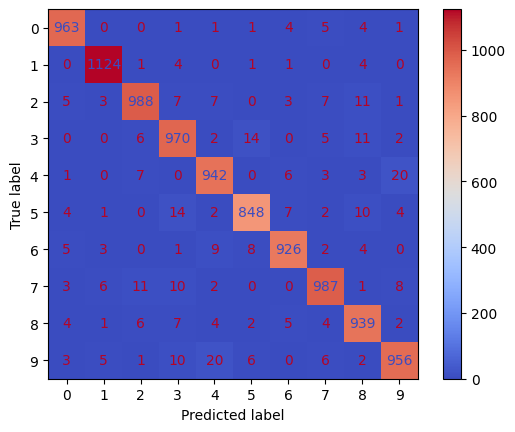

In [21]:
# побудуємо confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_classes = np.argmax(predicted_res, axis=1) # predicted_res представлено у вигляді вектора з імовірностями, тож нам потрібен індекс найищого значення

c_matrix = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.coolwarm)

In [22]:
# бачимо що наша модель має найбільші проблеми з 9 та 3, 4, з 8 та 2, 3, 5, з 3 та 9, 5, 2. 
# Тобто по факту тіж самі що і у звичайних смертних, які намагаються розшифрувати підпис лікаря. 
# найбілші проблеми у моделі з класифікацією числа 5. Можливо варто або збільшити кількість екземплярів цього класу, або ускладнити модель.

# додавання l2 регулярізації та Dropout внесли падіння результатів. Значно погіршилась похибка красифікації між 9 та 4